In [1]:
#!pip install /kaggle/input/mmdet3-wheels/addict-2.4.0-py3-none-any.whl
#!pip install /kaggle/input/mmdet3-wheels/mmengine-0.7.3-py3-none-any.whl
#!pip install /kaggle/input/mmdet3-wheels/mmcv-2.0.0-cp310-cp310-linux_x86_64.whl
#!pip install /kaggle/input/pycocotools-206/wheels/pycocotools-2.0.6-cp310-cp310-linux_x86_64.whl
#!pip install /kaggle/input/mmdet3-wheels/terminaltables-3.1.10-py2.py3-none-any.whl
#!pip install /kaggle/input/mmdet3-wheels/mmdet-3.0.0-py3-none-any.whl

# Import

In [2]:
import mmdet
import mmcv
import mmengine
from mmengine import Config
from mmengine.runner import set_random_seed
#from mmdet.datasets import build_dataset
#from mmdet.models import build_detector
from mmengine.runner import Runner
from mmdet.apis import init_detector, inference_detector
from mmengine.visualization import Visualizer

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import json

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.

from sklearn.model_selection import KFold, StratifiedKFold
from pytorch_lightning import seed_everything

# Config

In [4]:
class CFG:
    class general:
        #project_name = "HuBMAP2023"
        input_path = "../data/input"
        output_path = "../data/output"
        save_name = "convnext_small_fold"
        seed = 0
        cv = True
        #wandb_desabled = True
        n_splits = 5
        fold = [0] # list (0-idx start) or null. Set one element list, hold-out mode.

# Main

### Read data

In [5]:
tile_meta = pd.read_csv(f"{CFG.general.input_path}/tile_meta.csv")
polygons = pd.read_json(f"{CFG.general.input_path}/polygons.jsonl", lines=True)
train = pd.merge(polygons, tile_meta, on="id", how="left")
print(len(train))

1633


In [6]:
#train_not1 = train[train["dataset"]!=1].reset_index(drop=True)
#print(len(train_not1))

In [7]:
#train = train[train["dataset"]==1].reset_index(drop=True) # using only dataset1
#print(len(train))

In [8]:
valid_cv = train[(train["source_wsi"]==1) & (train["dataset"]==1)].reset_index(drop=True)
train_cv = train[(train["source_wsi"]!=1)].reset_index(drop=True)

In [9]:
with open(f"{CFG.general.input_path}/coco_annotations_all.json") as f:
    coco_json = json.load(f)

In [10]:
coco_info = pd.DataFrame(coco_json["info"])
coco_licenses = pd.DataFrame(coco_json["licenses"])
coco_categories = pd.DataFrame(coco_json["categories"])
coco_images = pd.DataFrame(coco_json["images"])
coco_annotations = pd.DataFrame(coco_json["annotations"])

In [11]:
"""
kf = KFold(
    n_splits=CFG.general.n_splits,
    shuffle=True,
    random_state=CFG.general.seed
)
"""

'\nkf = KFold(\n    n_splits=CFG.general.n_splits,\n    shuffle=True,\n    random_state=CFG.general.seed\n)\n'

In [12]:
if CFG.general.cv:
    for fold_n in CFG.general.fold:
        print(f"fold{fold_n}: create json")
        #train_indices, valid_indices = list(kf.split(train))[fold_n]
        #train_cv = train.iloc[train_indices].reset_index(drop=True)
        #valid_cv = train.iloc[valid_indices].reset_index(drop=True)
        
        # dataset1以外も訓練に使うかどうか？
        #train_cv = pd.concat([train_cv, train_not1]).reset_index(drop=True)

        coco_images_train = coco_images[coco_images["id"].isin(train_cv["id"])].reset_index(drop=True)
        coco_images_valid = coco_images[coco_images["id"].isin(valid_cv["id"])].reset_index(drop=True)
        
        coco_annotations_train = coco_annotations[coco_annotations["image_id"].isin(train_cv["id"])].reset_index(drop=True)
        coco_annotations_valid = coco_annotations[coco_annotations["image_id"].isin(valid_cv["id"])].reset_index(drop=True)
        
        # bloodだけにするかどうか
        coco_annotations_train = coco_annotations_train[coco_annotations_train["category_id"]==2].reset_index(drop=True)
        coco_annotations_valid = coco_annotations_valid[coco_annotations_valid["category_id"]==2].reset_index(drop=True)
        
        # unsureを除くかどうか
        #coco_annotations_train = coco_annotations_train[coco_annotations_train["category_id"]!=3].reset_index(drop=True)
        #coco_annotations_valid = coco_annotations_valid[coco_annotations_valid["category_id"]!=3].reset_index(drop=True)
        
        # glomerulusを除くかどうか
        #coco_annotations_train = coco_annotations_train[coco_annotations_train["category_id"]!=1].reset_index(drop=True)
        #coco_annotations_valid = coco_annotations_valid[coco_annotations_valid["category_id"]!=1].reset_index(drop=True)        
        
        # unsureをbloodにするかどうか
        #coco_annotations_train.loc[coco_annotations_train["category_id"]==3, "category_id"] = 2
        #coco_annotations_valid.loc[coco_annotations_valid["category_id"]==3, "category_id"] = 2
        
        coco_annotations_train["id"] = coco_annotations_train.index + 1
        coco_annotations_valid["id"] = coco_annotations_valid.index + 1

        coco_json_train = coco_json.copy()
        coco_json_valid = coco_json.copy()

        coco_json_train["categories"] = [coco_categories.iloc[1].to_dict()]
        coco_json_valid["categories"] = [coco_categories.iloc[1].to_dict()]
        #coco_json_train["categories"] = coco_categories.iloc[:2].to_dict(orient="records")
        #coco_json_valid["categories"] = coco_categories.iloc[:2].to_dict(orient="records")
        
        coco_json_train["images"] = coco_images_train.to_dict(orient="records")
        coco_json_train["annotations"] = coco_annotations_train.to_dict(orient="records")
        coco_json_valid["images"] = coco_images_valid.to_dict(orient="records")
        coco_json_valid["annotations"] = coco_annotations_valid.to_dict(orient="records")

        output_file_path = f"{CFG.general.input_path}/coco_annotations_train_fold{fold_n}.json"
        with open(output_file_path, "w", encoding="utf-8") as output_file:
            json.dump(coco_json_train, output_file, ensure_ascii=True, indent=4)

        output_file_path = f"{CFG.general.input_path}/coco_annotations_valid_fold{fold_n}.json"
        with open(output_file_path, "w", encoding="utf-8") as output_file:
            json.dump(coco_json_valid, output_file, ensure_ascii=True, indent=4)
            
        print(f"train annos: {len(coco_annotations_train)}, images: {len(coco_images_train)}")
        print(f"valid annos: {len(coco_annotations_valid)}, images: {len(coco_images_valid)}")
else:
    pass
    """
    print(f"fold all: create json")
    coco_annotations_train = coco_annotations_train[coco_annotations_train["category_id"]==2].reset_index(drop=True)
    coco_annotations_valid = coco_annotations_valid[coco_annotations_valid["category_id"]==2].reset_index(drop=True)
    coco_annotations_train["id"] = coco_annotations_train.index + 1
    coco_annotations_valid["id"] = coco_annotations_valid.index + 1
    
    coco_json_train = coco_json.copy()
    coco_json_valid = coco_json.copy()
    
    coco_json_train["categories"] = [coco_categories.iloc[1].to_dict()]
    coco_json_train["images"] = coco_images_train.to_dict(orient="records")
    coco_json_train["annotations"] = coco_annotations_train.to_dict(orient="records")
    coco_json_valid["categories"] = [coco_categories.iloc[1].to_dict()]
    coco_json_valid["images"] = coco_images_valid.to_dict(orient="records")
    coco_json_valid["annotations"] = coco_annotations_valid.to_dict(orient="records")
    
    output_file_path = f"coco_annotations_train_fold_all.json"
    with open(output_file_path, "w", encoding="utf-8") as output_file:
        json.dump(coco_json_train, output_file, ensure_ascii=True, indent=4)

    output_file_path = f"coco_annotations_valid_fold_all.json"
    with open(output_file_path, "w", encoding="utf-8") as output_file:
        json.dump(coco_json_valid, output_file, ensure_ascii=True, indent=4)
    """

fold0: create json
train annos: 11974, images: 1126
valid annos: 1182, images: 270


In [13]:
backbone = "convnext"
if backbone == "convnext":
    #cfg = Config.fromfile("../mmdetection/configs/convnext/cascade-mask-rcnn_convnext-t-p4-w7_fpn_4conv1fc-giou_amp-ms-crop-3x_coco.py")
    cfg = Config.fromfile("../mmdetection/configs/convnext/cascade-mask-rcnn_convnext-s-p4-w7_fpn_4conv1fc-giou_amp-ms-crop-3x_coco.py")
    #cfg.work_dir = ""
    #Runner.from_cfg(cfg)
    
    # cfg dataset
    cfg.metainfo = {
        #"classes": ("glomerulus", "blood_vessel", )
        "classes": ("blood_vessel", )
    }
    cfg.train_pipeline = [
            dict(type="LoadImageFromFile", backend_args=None),
            dict(type="LoadAnnotations", with_bbox=True, with_mask=True, poly2mask=True),
            dict(
                type="RandomChoiceResize",
                scales=[(640, 640), (768, 768), (896, 896), (1024, 1024), (1152, 1152), (1280, 1280), (1408, 1408), (1536, 1536)],
                keep_ratio=True),
            dict(
                type="RandomFlip",
                prob=0.0),
            dict(type="PackDetInputs")
        ]
    cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
    cfg.test_pipeline = [
            dict(type="LoadImageFromFile", backend_args=None),
            dict(type="Resize", scale=(1024, 1024), keep_ratio=True),
            dict(type="LoadAnnotations", with_bbox=True, with_mask=True),
            dict(
                type="PackDetInputs",
                meta_keys=("img_id", "img_path", "ori_shape", "img_shape", "scale_factor"))
        ]
    cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
    cfg.data_root = f"{CFG.general.input_path}"
    cfg.train_dataloader.dataset.ann_file = f"coco_annotations_train_fold{fold_n}.json"
    cfg.train_dataloader.dataset.data_root = cfg.data_root
    cfg.train_dataloader.dataset.data_prefix.img = "train"
    cfg.train_dataloader.dataset.metainfo = cfg.metainfo
    cfg.val_dataloader.dataset.ann_file = f"coco_annotations_valid_fold{fold_n}.json"
    cfg.val_dataloader.dataset.data_root = cfg.data_root
    cfg.val_dataloader.dataset.data_prefix.img = "train"
    cfg.val_dataloader.dataset.metainfo = cfg.metainfo
    cfg.test_dataloader = cfg.val_dataloader
    cfg.val_evaluator.ann_file = f"{CFG.general.input_path}/coco_annotations_valid_fold{fold_n}.json"
    cfg.val_evaluator.metric = "segm"
    cfg.test_evaluator = cfg.val_evaluator

    # classes
    cfg.model.roi_head.bbox_head[0].num_classes = 1
    cfg.model.roi_head.bbox_head[1].num_classes = 1
    cfg.model.roi_head.bbox_head[2].num_classes = 1
    cfg.model.roi_head.mask_head.num_classes = 1

    # pretrained weight
    #cfg.load_from = "../data/pretrained_weight/cascade_mask_rcnn_convnext-t_p4_w7_fpn_giou_4conv1f_fp16_ms-crop_3x_coco_20220509_204200-8f07c40b.pth"
    cfg.load_from = "../data/pretrained_weight/cascade_mask_rcnn_convnext-s_p4_w7_fpn_giou_4conv1f_fp16_ms-crop_3x_coco_20220510_201004-3d24f5a4.pth"
                          
    # Set up working dir to save files and logs
    cfg.work_dir = f"{CFG.general.output_path}/{CFG.general.save_name}"

    # training configs, learning rate, optimizer
    max_iter = 5000
    cfg.train_cfg = dict(type="IterBasedTrainLoop", max_iters=max_iter, val_interval=500)
    cfg.train_dataloader.sampler = dict(type="InfiniteSampler", shuffle=True)
    cfg.log_processor = dict(by_epoch=False)
    cfg.optim_wrapper.type = "AmpOptimWrapper"
    #cfg.optim_wrapper.optimizer = dict(type="AdamW", lr=0.0000002, betas=(0.9, 0.999,), weight_decay=0.05)
    cfg.param_scheduler = [
            dict(
                type="LinearLR", start_factor=1.0e-3, by_epoch=False, begin=0, end=int(max_iter*0.1)),
            dict(
                type="CosineAnnealingLR",
                T_max=max_iter-int(max_iter*0.1),
                by_epoch=False,
                begin=int(max_iter*0.1),
                end=max_iter)
        ]

    # logger
    cfg.default_hooks.checkpoint.interval = 0
    cfg.default_hooks.logger.interval = 100

    # Set seed thus the results are more reproducible
    set_random_seed(CFG.general.seed, deterministic=False)
    
elif backbone == "resnet":
    cfg = Config.fromfile("../mmdetection/configs/cascade_rcnn/cascade-mask-rcnn_r50_fpn_ms-3x_coco.py")
    #cfg = Config.fromfile("../mmdetection/configs/cascade_rcnn/cascade-mask-rcnn_x101-64x4d_fpn_ms-3x_coco.py")
    
    # cfg dataset
    cfg.metainfo = {
        "classes": ("blood_vessel", )
    }
    cfg.train_pipeline = [
            dict(type="LoadImageFromFile", backend_args=None),
            dict(type="LoadAnnotations", with_bbox=True, with_mask=True, poly2mask=True),
            dict(
                type="RandomChoiceResize",
                scales=[(640, 640), (768, 768), (896, 896), (1024, 1024), (1152, 1152), (1280, 1280), (1408, 1408), (1536, 1536)],
                keep_ratio=True),
            dict(type="RandomFlip", prob=0.0),
            #dict(type="RandomFlip", direction=["horizontal", "vertical"], prob=[0.5, 0.5]),
            dict(type="PackDetInputs")
        ]
    cfg.train_dataloader.dataset.dataset.pipeline = cfg.train_pipeline
    cfg.test_pipeline = [
            dict(type="LoadImageFromFile", backend_args=None),
            dict(type="Resize", scale=(1024, 1024), keep_ratio=True),
            dict(type="LoadAnnotations", with_bbox=True, with_mask=True),
            dict(
                type="PackDetInputs",
                meta_keys=("img_id", "img_path", "ori_shape", "img_shape", "scale_factor"))
        ]
    cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
    cfg.data_root = f"{CFG.general.input_path}"
    cfg.train_dataloader.dataset.dataset.ann_file = f"coco_annotations_train_fold{fold_n}.json"
    cfg.train_dataloader.dataset.dataset.data_root = cfg.data_root
    cfg.train_dataloader.dataset.dataset.data_prefix.img = "train"
    cfg.train_dataloader.dataset.dataset.metainfo = cfg.metainfo
    cfg.val_dataloader.dataset.ann_file = f"coco_annotations_valid_fold{fold_n}.json"
    cfg.val_dataloader.dataset.data_root = cfg.data_root
    cfg.val_dataloader.dataset.data_prefix.img = "train"
    cfg.val_dataloader.dataset.metainfo = cfg.metainfo
    cfg.test_dataloader = cfg.val_dataloader
    cfg.val_evaluator.ann_file = f"{CFG.general.input_path}/coco_annotations_valid_fold{fold_n}.json"
    cfg.val_evaluator.metric = "segm"
    cfg.test_evaluator = cfg.val_evaluator

    # classes
    cfg.model.roi_head.bbox_head[0].num_classes = 1
    cfg.model.roi_head.bbox_head[1].num_classes = 1
    cfg.model.roi_head.bbox_head[2].num_classes = 1
    cfg.model.roi_head.mask_head.num_classes = 1

    # pretrained weight
    cfg.load_from = "../data/pretrained_weight/cascade_mask_rcnn_r50_fpn_mstrain_3x_coco_20210628_164719-5bdc3824.pth"
    #cfg.load_from = "../data/pretrained_weight/cascade_mask_rcnn_x101_64x4d_fpn_mstrain_3x_coco_20210719_210311-d3e64ba0.pth"

    # Set up working dir to save files and logs
    cfg.work_dir = f"{CFG.general.output_path}/{CFG.general.save_name}"

    # training configs, learning rate, optimizer
    max_iter = 5000
    cfg.train_cfg = dict(type="IterBasedTrainLoop", max_iters=max_iter, val_interval=500)
    cfg.train_dataloader.sampler = dict(type="InfiniteSampler", shuffle=True)
    cfg.log_processor = dict(by_epoch=False)
    cfg.optim_wrapper.type = "AmpOptimWrapper"
    cfg.optim_wrapper.optimizer.type = "SGD"
    cfg.optim_wrapper.optimizer.lr = 1.0e-2
    cfg.optim_wrapper.optimizer.weight_decay = 1.0e-5
    cfg.param_scheduler = [
            dict(
                type="LinearLR", start_factor=1.0e-3, by_epoch=False, begin=0, end=int(max_iter*0.1)),
            dict(
                type="CosineAnnealingLR",
                T_max=max_iter-int(max_iter*0.1),
                by_epoch=False,
                begin=int(max_iter*0.1),
                end=max_iter)
        ]

    # logger
    cfg.default_hooks.checkpoint.interval = 0
    cfg.default_hooks.logger.interval = 100

    # Set seed thus the results are more reproducible
    set_random_seed(CFG.general.seed, deterministic=False)

elif backbone == "mask2former":
    cfg = Config.fromfile("../mmdetection/configs/mask2former/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco.py")
    #cfg.work_dir = "../../"
    #Runner.from_cfg(cfg)
    
    # cfg dataset
    cfg.metainfo = {
        "classes": ("blood_vessel", )
    }
    cfg.train_pipeline[2] = dict(type="RandomFlip", prob=0.0)
    cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
    cfg.test_pipeline[1] = dict(type="Resize", scale=(1024, 1024), keep_ratio=True)
    cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
    cfg.data_root = f"{CFG.general.input_path}"
    cfg.train_dataloader.dataset.ann_file = f"coco_annotations_train_fold{fold_n}.json"
    cfg.train_dataloader.dataset.data_root = cfg.data_root
    cfg.train_dataloader.dataset.data_prefix.img = "train"
    cfg.train_dataloader.dataset.metainfo = cfg.metainfo
    cfg.val_dataloader.dataset.ann_file = f"coco_annotations_valid_fold{fold_n}.json"
    cfg.val_dataloader.dataset.data_root = cfg.data_root
    cfg.val_dataloader.dataset.data_prefix.img = "train"
    cfg.val_dataloader.dataset.metainfo = cfg.metainfo
    cfg.test_dataloader = cfg.val_dataloader
    cfg.val_evaluator.ann_file = f"{CFG.general.input_path}/coco_annotations_valid_fold{fold_n}.json"
    cfg.val_evaluator.metric = "segm"
    cfg.test_evaluator = cfg.val_evaluator

    # classes
    cfg.num_things_classes = 1
    cfg.num_classes = 1
    cfg.model.panoptic_head.num_things_classes = cfg.num_things_classes
    cfg.model.panoptic_head.num_stuff_classes = cfg.num_stuff_classes
    cfg.model.panoptic_fusion_head.num_things_classes = cfg.num_things_classes
    cfg.model.panoptic_fusion_head.num_stuff_classes = cfg.num_stuff_classes
    cfg.model.panoptic_head.loss_cls["class_weight"] = [1.0] * cfg.num_classes + [0.1]

    # pretrained weight
    cfg.load_from = "../data/pretrained_weight/mask2former_swin-t-p4-w7-224_8xb2-lsj-50e_coco_20220508_091649-01b0f990.pth"

    # Set up working dir to save files and logs
    cfg.work_dir = f"{CFG.general.output_path}/{CFG.general.save_name}"

    # training configs, learning rate, optimizer
    max_iter = 10000
    cfg.train_cfg = dict(type="IterBasedTrainLoop", max_iters=max_iter, val_interval=500)
    cfg.train_dataloader.sampler = dict(type="InfiniteSampler", shuffle=True)
    cfg.log_processor = dict(by_epoch=False)
    cfg.optim_wrapper.type = "AmpOptimWrapper"
    #cfg.optim_wrapper.optimizer = dict(type="SGD", lr=0.01, momentum=0.9, weight_decay=1e-05)
    cfg.param_scheduler = [
            dict(
                type="LinearLR", start_factor=1.0e-3, by_epoch=False, begin=0, end=int(max_iter*0.1)),
            dict(
                type="CosineAnnealingLR",
                T_max=max_iter-int(max_iter*0.1),
                by_epoch=False,
                begin=int(max_iter*0.1),
                end=max_iter)
        ]

    # logger
    cfg.default_hooks.checkpoint.interval = 0
    cfg.default_hooks.logger.interval = 100

    # Set seed thus the results are more reproducible
    set_random_seed(CFG.general.seed, deterministic=False)

In [14]:
runner = Runner.from_cfg(cfg)

07/29 03:20:17 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.16 (main, Dec  7 2022, 01:11:51) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 209652396
    GPU 0: NVIDIA RTX A6000
    CUDA_HOME: /usr/local/cuda-11.6
    NVCC: Cuda compilation tools, release 11.6, V11.6.124
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 1.12.1+cu116
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.6
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=co

In [15]:
seed_everything(CFG.general.seed, workers=True)
runner.train()

Global seed set to 0


loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
07/29 03:20:24 - mmengine - INFO - self.paramwise_cfg is {'decay_rate': 0.7, 'decay_type': 'layer_wise', 'num_layers': 12}
07/29 03:20:24 - mmengine - INFO - Build LearningRateDecayOptimizerConstructor  layer_wise 0.7 - 14
07/29 03:20:24 - mmengine - INFO - set param backbone.downsample_layers.0.0.weight as id 0
07/29 03:20:24 - mmengine - INFO - set param backbone.downsample_layers.0.0.bias as id 0
07/29 03:20:24 - mmengine - INFO - set param backbone.downsample_layers.0.1.weight as id 0
07/29 03:20:24 - mmengine - INFO - set param backbone.downsample_layers.0.1.bias as id 0
07/29 03:20:24 - mmengine - INFO - set param backbone.downsample_layers.1.0.weight as id 2
07/29 03:20:24 - mmengine - INFO - set param backbone.downsample_layers.1.0.bias as id 2
07/29 03:20:24 - mmengine - INFO - set param backbone.downsample_layers.1.1.weight as id 2
07/29 03:20:24 - mmengine - INFO - set param backbone.downsampl

Downloading: "https://download.openmmlab.com/mmclassification/v0/convnext/downstream/convnext-small_3rdparty_32xb128-noema_in1k_20220301-303e75e3.pth" to /root/.cache/torch/hub/checkpoints/convnext-small_3rdparty_32xb128-noema_in1k_20220301-303e75e3.pth


07/29 03:22:47 - mmengine - WARNING - The model and loaded state dict do not match exactly

missing keys in source state_dict: norm0.weight, norm0.bias, norm1.weight, norm1.bias, norm2.weight, norm2.bias, norm3.weight, norm3.bias

Loads checkpoint by local backend from path: ../data/pretrained_weight/cascade_mask_rcnn_convnext-s_p4_w7_fpn_giou_4conv1f_fp16_ms-crop_3x_coco_20220510_201004-3d24f5a4.pth
The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.0.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([2, 1024]).
size mismatch for roi_head.bbox_head.0.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for roi_head.bbox_head.0.fc_reg.weight: copying a param with shape torch.Size([320, 1024]) from checkpoint, the shape in current model is torch.Size([4, 1024]).
size mismatch for roi_head.bbox_h

CascadeRCNN(
  (data_preprocessor): DetDataPreprocessor()
  (backbone): ConvNeXt(
    (downsample_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
      )
      (1): Sequential(
        (0): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
        (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
      )
      (2): Sequential(
        (0): LayerNorm2d((192,), eps=1e-06, elementwise_affine=True)
        (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
      )
      (3): Sequential(
        (0): LayerNorm2d((384,), eps=1e-06, elementwise_affine=True)
        (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (stages): ModuleList(
      (0): Sequential(
        (0): ConvNeXtBlock(
          (depthwise_conv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm2d((96,), ep

# Val

In [16]:
"""
runs = []
for size in [640, 768, 896, 1024, 1152, 1280, 1408, 1536]:
    print(f"[{size}]")
    cfg.load_from = f"{CFG.general.output_path}/{CFG.general.save_name}/epoch_1.pth"
    #cfg.load_from = f"{CFG.general.output_path}/{CFG.general.save_name}/iter_10000.pth"
    cfg.test_pipeline = [
            dict(type="LoadImageFromFile", backend_args=None),
            dict(type="Resize", scale=(size, size), keep_ratio=True),
            dict(type="LoadAnnotations", with_bbox=True, with_mask=True),
            dict(
                type="PackDetInputs",
                meta_keys=("img_id", "img_path", "ori_shape", "img_shape", "scale_factor"))
        ]
    cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
    runner = Runner.from_cfg(cfg)
    runs.append(runner)
"""

'\nruns = []\nfor size in [640, 768, 896, 1024, 1152, 1280, 1408, 1536]:\n    print(f"[{size}]")\n    cfg.load_from = f"{CFG.general.output_path}/{CFG.general.save_name}/epoch_1.pth"\n    #cfg.load_from = f"{CFG.general.output_path}/{CFG.general.save_name}/iter_10000.pth"\n    cfg.test_pipeline = [\n            dict(type="LoadImageFromFile", backend_args=None),\n            dict(type="Resize", scale=(size, size), keep_ratio=True),\n            dict(type="LoadAnnotations", with_bbox=True, with_mask=True),\n            dict(\n                type="PackDetInputs",\n                meta_keys=("img_id", "img_path", "ori_shape", "img_shape", "scale_factor"))\n        ]\n    cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline\n    runner = Runner.from_cfg(cfg)\n    runs.append(runner)\n'

In [17]:
#for run_, size in zip(runs, [640, 768, 896, 1024, 1152, 1280, 1408, 1536]):
#    print(f"[{size}]")
#    run_.val()

In [18]:
# 640 -> 406, 768 -> 422, 896 -> 428, 1024 -> 440, 1152 -> 433, 1280 -> 439, 1408 -> 431, 1536 -> 420

# resnext
# 640 -> 410, 768 -> 435, 896 -> 441, 1024 -> 440, 1152 -> 441, 1280 -> 443, 1408 -> 432, 1536 -> 429

# convnext tiny
# 640 -> 435, 768 -> 449, 896 -> 454, 1024 -> 455, 1152 -> 456, 1280 -> 453, 1408 -> 450, 1536 -> 443

In [19]:
img = mmcv.imread(f"{CFG.general.input_path}/train/0006ff2aa7cd.tif", channel_order="rgb")
checkpoint_file = f"{CFG.general.output_path}/{CFG.general.save_name}/epoch_1.pth"
model = init_detector(cfg, checkpoint_file)
new_result = inference_detector(model, img)
print(new_result)

Loads checkpoint by local backend from path: ../data/output/convnext_small_fold/epoch_1.pth
<DetDataSample(

    META INFORMATION
    batch_input_shape: (1024, 1024)
    pad_shape: (1024, 1024)
    img_shape: (1024, 1024)
    img_path: None
    ori_shape: (512, 512)
    scale_factor: (2.0, 2.0)
    img_id: 0

    DATA FIELDS
    ignored_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            labels: tensor([], device='cuda:0', dtype=torch.int64)
            masks: BitmapMasks(num_masks=0, height=512, width=512)
            bboxes: tensor([], device='cuda:0', size=(0, 4))
        ) at 0x7f161f369d60>
    pred_instances: <InstanceData(
        
            META INFORMATION
        
            DATA FIELDS
            scores: tensor([0.9553, 0.9405, 0.8005, 0.7486, 0.7362, 0.5073, 0.4802, 0.3583, 0.1626,
                        0.1360, 0.1235, 0.1041, 0.0986, 0.0960, 0.0805, 0.0716, 0.0594, 0.0545],
                       device='cuda:0

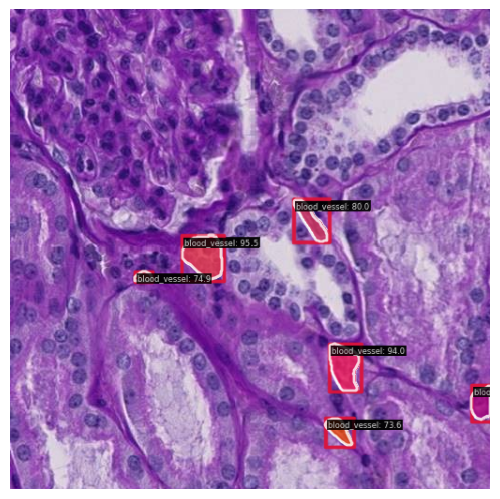

In [20]:
# get built visualizer
visualizer_now = Visualizer.get_current_instance()
# the dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer_now.dataset_meta = model.dataset_meta
# show the results
visualizer_now.add_datasample(
    "new_result",
    img,
    data_sample=new_result,
    draw_gt=False,
    wait_time=0,
    out_file=None,
    pred_score_thr=0.5
)
visualizer_now.show()